In [45]:
!wget https://dataworks.indianapolis.iu.edu/bitstream/handle/11243/41/data.zip
!unzip -q data.zip
!rm data.zip

--2024-06-16 09:30:19--  https://dataworks.indianapolis.iu.edu/bitstream/handle/11243/41/data.zip
Resolving dataworks.indianapolis.iu.edu (dataworks.indianapolis.iu.edu)... 134.68.190.8, 2001:18e8:3:be::105
Connecting to dataworks.indianapolis.iu.edu (dataworks.indianapolis.iu.edu)|134.68.190.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data.zip’

data.zip                [      <=>           ] 891.30M  30.3MB/s    in 29s     

2024-06-16 09:30:49 (30.3 MB/s) - ‘data.zip’ saved [934596904]



# Imports and device settings

In [46]:
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import reduce

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Dataset definition

## Training dataset
- Number of samples: 12481.
- Number of seen species: 652.


In [47]:
class ImageDNATrainDataset():
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1

        TRAINING_SAMPLES_NUMBER = 12481
        TRAINING_LABELS_NUMBER = 652

        assert len(train_loc[0]) == TRAINING_SAMPLES_NUMBER

        indeces = train_loc
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(
            data_mat["embeddings_img"][indeces]
        ).float()
        self.embeddings_dna = torch.from_numpy(
            data_mat["embeddings_dna"][indeces]
        ).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        species_mapping = seen_species_mapping
        assert len(species_mapping) == TRAINING_LABELS_NUMBER

        species = data_mat["labels"][indeces]
        remapped_species = np.array([species_mapping[label.item()] for label in species])
        self.remapped_species = torch.from_numpy(remapped_species).long()

        assert len(torch.unique(self.remapped_species)) == TRAINING_LABELS_NUMBER

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        assert len(self.genera) == TRAINING_SAMPLES_NUMBER

        self.species_names = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_species[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

## Validation set
- Number of samples: 6939.
- Number of seen species of the training set in the validation set: 629.
- Number of unseen species in the validation set: 97

In [48]:
class ImageDNAValidationDataset():
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_LABELS_NUMBER = 652
        VALIDATION_SAMPLES_NUMBER = 6939
        VALIDATION_SPECIES_NUMBER = 774
        TRAINING_VALIDATION_SPECIES_NUMBER = 797
        VALIDATION_SEEN_SPECIES_NUMBER = 629
        VALIDATION_UNSEEN_SPECIES_GENERA_NUMBER = 97

        indeces = np.concatenate((val_seen_loc, val_unseen_loc), axis=1)
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]
        assert len(indeces) == VALIDATION_SAMPLES_NUMBER

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species = data_mat["labels"][val_unseen_loc][0]
        unseen_species_mapping = {label: i + TRAINING_LABELS_NUMBER for i, label in enumerate(np.unique(unseen_species))}

        # Union of the two mappings, allows to fully remap all the labels
        species_mapping = seen_species_mapping | unseen_species_mapping
        assert len(species_mapping) == TRAINING_VALIDATION_SPECIES_NUMBER

        species = data_mat["labels"][indeces]
        remapped_species = np.array([species_mapping[label.item()] for label in species])
        self.remapped_species = torch.from_numpy(remapped_species).long()
        assert len(torch.unique(self.remapped_species)) == VALIDATION_SPECIES_NUMBER

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        # Compute genera of unseen species in the validation set
        unseen_species_genera = []
        for i in val_unseen_loc[0]:
            unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)
        self.unseen_species_genera = np.array(unseen_species_genera)
        assert len(np.unique(self.unseen_species_genera)) == VALIDATION_UNSEEN_SPECIES_GENERA_NUMBER

        # Compute seen species number in the validation set
        seen_species = []
        for i in val_seen_loc[0]:
            seen_species.append(species_mapping[data_mat["labels"][i].item()])
        self.seen_species = np.array(seen_species)
        assert len(np.unique(self.seen_species)) == VALIDATION_SEEN_SPECIES_NUMBER

        self.species_names = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_species[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

## Test set
- Number of samples: 13428.
- Number of seen species of the training and validation set in the test set: 770.
- Number of unseen species in the test set: 134

In [49]:
class ImageDNATestDataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_SPECIES_NUMBER = 652
        TRAINING_VALIDATION_SPECIES = 797
        NUMBER_OF_SPECIES = 1040
        TEST_SEEN_SPECIES_NUMBER = 770
        TEST_UNSEEN_SPECIES_GENERA_NUMBER = 134

        indeces = np.concatenate((test_seen_loc, test_unseen_loc), axis=1)
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species_validation = data_mat["labels"][val_unseen_loc][0]
        unseen_species_validation_mapping = {label: i + TRAINING_SPECIES_NUMBER for i, label in enumerate(np.unique(unseen_species_validation))}

        # Remap unseen species during test in [797, 1039]
        unseen_species_test = data_mat["labels"][test_unseen_loc][0]
        unseen_species_test_mapping = {label: i + TRAINING_VALIDATION_SPECIES for i, label in enumerate(np.unique(unseen_species_test))}

        assert reduce(np.intersect1d, (seen_species, unseen_species_validation, unseen_species_test)).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = seen_species_mapping | unseen_species_validation_mapping | unseen_species_test_mapping
        assert len(labels_mapping) == NUMBER_OF_SPECIES

        species = data_mat["labels"][indeces]
        remapped_labels = np.array([labels_mapping[label.item()] for label in species])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        # Compute genera of unseen species
        unseen_species_genera = []
        for i in test_unseen_loc[0]:
            unseen_species_genera.append(data_mat["G"][data_mat["labels"][i][0] - 1][0] - 1041)

        self.unseen_species_genera = np.array(unseen_species_genera)
        assert len(np.unique(self.unseen_species_genera)) == TEST_UNSEEN_SPECIES_GENERA_NUMBER

        # Compute seen species
        seen_species = []
        for i in test_seen_loc[0]:
            seen_species.append(labels_mapping[data_mat["labels"][i].item()])
        self.seen_species = np.array(seen_species)
        assert len(np.unique(self.seen_species)) == TEST_SEEN_SPECIES_NUMBER

        self.species_name = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera

    def get_species_name(self, species):
        for idx in range(len(self.remapped_labels)):
            if self.remapped_labels[idx].item() == species:
                return self.species_name[idx].item()[0]
        return None
    def get_genera_name(self, genera):
        for idx in range(len(self.genera)):
            if self.genera[idx].item() == genera:
                return self.species_name[idx].item()[0].split()[0]
        return None

## Training and validation dataset
Union of the training and validation splits, employed to train the final model after the validation phase.

In [50]:
class ImageDNATrainValidationDataset(Dataset):
    def __init__(self, train=True):
        splits_mat = scipy.io.loadmat("data/INSECTS/splits.mat")
        train_loc = splits_mat["train_loc"]-1
        trainval_loc = splits_mat["trainval_loc"]-1
        test_seen_loc = splits_mat["test_seen_loc"]-1
        test_unseen_loc = splits_mat["test_unseen_loc"]-1
        val_seen_loc = splits_mat["val_seen_loc"]-1
        val_unseen_loc = splits_mat["val_unseen_loc"]-1

        TRAINING_SPECIES_NUMBER = 652
        TRAINING_VALIDATION_SPECIES = 797
        NUMBER_OF_SPECIES = 1040

        indeces = trainval_loc
        # indeces.shape is (1, |indeces|), so we extract the whole list using [0]
        indeces = indeces[0]

        data_mat = scipy.io.loadmat("data/INSECTS/data.mat")
        self.embeddings_img = torch.from_numpy(data_mat["embeddings_img"][indeces]).float()
        self.embeddings_dna = torch.from_numpy(data_mat["embeddings_dna"][indeces]).float()

        # Remap seen species in [0, 651]
        seen_species = data_mat["labels"][train_loc][0]
        seen_species_mapping = {label: i for i, label in enumerate(np.unique(seen_species))}

        # Remap unseen species during validation in [652, 796]
        unseen_species_validation = data_mat["labels"][val_unseen_loc][0]
        unseen_species_validation_mapping = {label: i + TRAINING_SPECIES_NUMBER for i, label in enumerate(np.unique(unseen_species_validation))}

        # Remap unseen species during test in [797, 1039]
        unseen_species_test = data_mat["labels"][test_unseen_loc][0]
        unseen_species_test_mapping = {label: i + TRAINING_VALIDATION_SPECIES for i, label in enumerate(np.unique(unseen_species_test))}

        assert reduce(np.intersect1d, (seen_species, unseen_species_validation, unseen_species_test)).size == 0

        # Union of the two mappings, allows to full remap all the labels
        labels_mapping = seen_species_mapping | unseen_species_validation_mapping | unseen_species_test_mapping
        assert len(labels_mapping) == NUMBER_OF_SPECIES

        species = data_mat["labels"][indeces]  # Consider only train
        remapped_labels = np.array([labels_mapping[label.item()] for label in species])
        self.remapped_labels = torch.from_numpy(remapped_labels).long()

        assert len(torch.unique(self.remapped_labels)) == TRAINING_VALIDATION_SPECIES

        # data_mat['G'] returns a ndarray of type uint16, therefore we convert into int16 before invoking from_numpy
        self.G = torch.from_numpy(data_mat["G"].astype(np.int16)).long()
        self.genera = torch.empty(species.shape).long()
        for i in range(indeces.size):
            self.genera[i][0] = self.G[species[i][0] - 1][0] - 1041

        self.species = data_mat["species"][indeces]
        self.ids = data_mat["ids"][indeces]

    def __len__(self):
        return len(self.embeddings_dna)

    def __getitem__(self, idx):
        embedding_img = self.embeddings_img[idx]
        embedding_dna = self.embeddings_dna[idx]
        label = self.remapped_labels[idx].item()
        genera = self.genera[idx].item()

        return embedding_img.view(1, -1), embedding_dna.view(1, -1), label, genera


# Model definition

In [51]:
class ImageDNACrossAttentionNet(nn.Module):
        def __init__(self, num_seen_species, num_genera):
                super(ImageDNACrossAttentionNet, self).__init__()
                self.fc_img = nn.Linear(2048, 512)
                self.fc_dna = nn.Linear(500, 512)
                self.img_dna_encoder_1 = ImageDNASlimEncoder(512, 2)
                self.img_dna_encoder_2 = ImageDNASlimEncoder(512, 2)
                self.fc_species = nn.Linear(1024, num_seen_species)
                self.fc_genera = nn.Linear(1024, num_genera)

        def forward(self, x_img, x_dna):
                x_img = self.fc_img(x_img)
                x_dna = self.fc_dna(x_dna)

                x_img, x_dna = self.img_dna_encoder_1(x_img, x_dna)
                x_img, x_dna = F.gelu(x_img), F.gelu(x_dna)
                x_img, x_dna = self.img_dna_encoder_2(x_img, x_dna)

                x = torch.cat((x_img, x_dna), axis=2)
                x = torch.squeeze(x, dim=1)
                x_species = self.fc_species(x)
                x_genera = self.fc_genera(x)

                return x_species, x_genera

class ImageDNASlimEncoder(nn.Module):
        def __init__(self, embed_dim, num_heads):
                super(ImageDNASlimEncoder, self).__init__()
                self.multi_head_img = nn.MultiheadAttention(embed_dim, num_heads)
                self.multi_head_dna = nn.MultiheadAttention(embed_dim, num_heads)
                self.norm_img = nn.LayerNorm(embed_dim)
                self.norm_dna = nn.LayerNorm(embed_dim)

        def forward(self, x_img, x_dna):
                identity = x_img
                x_img_out, _ = self.multi_head_img(x_img, x_dna, x_dna)
                x_img_out = self.norm_img(x_img_out + identity)

                identity = x_dna
                x_dna_out, _ = self.multi_head_dna(x_dna, x_img, x_img)
                x_dna_out = self.norm_dna(x_dna_out + identity)

                return x_img_out, x_dna_out

# Creating datasets

In [52]:
training_set = ImageDNATrainDataset()
validation_set = ImageDNAValidationDataset()
test_set = ImageDNATestDataset()
training_validation_set = ImageDNATrainValidationDataset()

Defining methods for training, validating and testing the model.

# Training, validation and testing

## Validation
Returns the described validation accuracy by species and the undescribed validation accuracy by genus.

In [53]:
def validate(model, threshold, batch_size):

    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    model.eval()

    with torch.no_grad():
        correct_predictions_per_species = defaultdict(int)
        total_samples_per_species = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        for data in validation_loader:
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            species_outputs, genera_outputs = model(inputs_img, inputs_dna)

            species_outputs = nn.Softmax(dim=1)(species_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_species_values, predicted_species = torch.topk(species_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_species_values[:, 0] - predicted_species_values[:, 1]
            genera_mask = differences <= threshold
            species_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_species[species[idx].item()] += 1

                if species_mask[idx] and predicted_species[idx, 0] == species[idx]:
                    correct_predictions_per_species[species[idx].item()] += 1

                # if the sample is of one undescribed species
                if species[idx].item() not in np.unique(validation_set.seen_species):
                    assert genera[idx].item() in np.unique(validation_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1

        accuracy_per_label = {label: (correct_predictions_per_species[label] / total_samples_per_species[label]) if total_samples_per_species[label] > 0 else 0 for label in total_samples_per_species}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(validation_set.seen_species):
            test_described_species_accuracy += accuracy_per_label[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(validation_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        normalized_test_described_species_accuracy = test_described_species_accuracy / 629
        normalized_test_undescribed_species_accuracy = test_undescribed_species_accuracy / 97

        return normalized_test_described_species_accuracy, normalized_test_undescribed_species_accuracy

## Validation genera loss
Computes the validation genera loss of the model.

In [54]:
def validate_loss(model, batch_size):
        criterion_species = torch.nn.CrossEntropyLoss()
        criterion_genera = torch.nn.CrossEntropyLoss()
        validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)
        model.eval()
        validation_genera_loss = 0.0
        validation_species_loss = 0.0
        with torch.no_grad():
            seen_species_samples_count = 0
            for data in validation_loader:
                inputs_img, inputs_dna, species, genera = data
                inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

                # Genera loss
                _, genera_outputs = model(inputs_img, inputs_dna)
                validation_genera_loss += criterion_genera(genera_outputs, genera).item() * inputs_img.size(0)

                # Species loss
                seen_mask = species < 652
                seen_inputs_img = inputs_img[seen_mask]
                seen_inputs_dna = inputs_dna[seen_mask]
                seen_species = species[seen_mask]
                seen_genera = genera[seen_mask]
                seen_species_samples_count += seen_inputs_img.size(0)
                seen_species_outputs, _ = model(seen_inputs_img, seen_inputs_dna)
                validation_species_loss += criterion_species(seen_species_outputs, seen_species).item() * seen_inputs_img.size(0)

        validation_genera_loss = validation_genera_loss / len(validation_loader.dataset)
        validation_species_loss = validation_species_loss / seen_species_samples_count
        return validation_species_loss, validation_genera_loss

## Test
Returns the described test accuracy by species and the undescribed validation accuracy by genus.

In [55]:
def test(model, threshold, batch_size):
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    model.eval()

    with torch.no_grad():
        correct_predictions_per_species = defaultdict(int)
        total_samples_per_species = defaultdict(int)
        correct_predictions_per_genera = defaultdict(int)
        total_samples_per_genera = defaultdict(int)

        for data in test_loader:
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            species_outputs, genera_outputs = model(inputs_img, inputs_dna)

            species_outputs = nn.Softmax(dim=1)(species_outputs)
            genera_outputs = nn.Softmax(dim=1)(genera_outputs)

            predicted_species_values, predicted_species = torch.topk(species_outputs.data, k=2, dim=1)
            _, predicted_genera = torch.max(genera_outputs.data, 1)

            differences = predicted_species_values[:, 0] - predicted_species_values[:, 1]
            genera_mask = differences <= threshold
            species_mask = ~genera_mask

            # Update relative frequencies
            for idx in range(len(genera)):
                total_samples_per_species[species[idx].item()] += 1

                if species_mask[idx] and predicted_species[idx, 0] == species[idx]:
                    correct_predictions_per_species[species[idx].item()] += 1

                # if the sample is of one undescribed species
                if species[idx].item() not in np.unique(test_set.seen_species):
                    assert genera[idx].item() in np.unique(test_set.unseen_species_genera)
                    total_samples_per_genera[genera[idx].item()] += 1

                    if genera_mask[idx] and predicted_genera[idx] == genera[idx]:
                        correct_predictions_per_genera[genera[idx].item()] += 1

        accuracy_per_species = {label: (correct_predictions_per_species[label] / total_samples_per_species[label]) if total_samples_per_species[label] > 0 else 0 for label in total_samples_per_species}
        accuracy_per_genera = {genera: (correct_predictions_per_genera[genera] / total_samples_per_genera[genera]) if total_samples_per_genera[genera] > 0 else 0 for genera in total_samples_per_genera}

        test_described_species_accuracy = 0
        for label in np.unique(test_set.seen_species):
            test_described_species_accuracy += accuracy_per_species[label]

        test_undescribed_species_accuracy = 0
        for genera in np.unique(test_set.unseen_species_genera):
            test_undescribed_species_accuracy += accuracy_per_genera[genera]

        normalized_test_described_species_accuracy = test_described_species_accuracy / 770
        normalized_test_undescribed_species_accuracy = test_undescribed_species_accuracy / 134

        return normalized_test_described_species_accuracy, normalized_test_undescribed_species_accuracy, accuracy_per_species, accuracy_per_genera

## Training
Trains the model on the training split with early stopping. Returns the genera loss of the model at the end of the training.

In [56]:
def train(model, lr, momentum, max_epochs, batch_size, print_losses=False, print_step=200):
    BEST_MODEL_NAME = "best_model.pth"

    model.train()
    criterion_species = torch.nn.CrossEntropyLoss()
    criterion_genera = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

    # Variables for early stopping
    validation_species_loss = 0
    validation_genera_loss = 0
    training_species_loss = 0
    training_genera_loss = 0
    best_validation_loss = np.inf
    optimal_training_epochs = max_epochs

    for epoch in range(max_epochs):
        model.train()
        running_species_loss = 0.0
        running_genera_loss = 0.0

        for i, data in enumerate(loader, 0):
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            species_outputs, genera_outputs = model(inputs_img, inputs_dna)
            species_loss = criterion_species(species_outputs, species)
            genera_loss = criterion_genera(genera_outputs, genera)
            total_loss = species_loss + genera_loss
            total_loss.backward()
            optimizer.step()
            scheduler.step()

            # Print losses
            if print_losses:
                running_species_loss += species_loss.item()
                running_genera_loss += genera_loss.item()
                if i % print_step == print_step - 1:
                    print(f"[{epoch + 1}, {i + 1:5d}] Species loss: {running_species_loss / print_step}; Genera loss: {running_genera_loss / print_step}")
                    training_species_loss = running_species_loss / print_step
                    training_genera_loss = running_genera_loss / print_step
                    running_species_loss = 0.0
                    running_genera_loss = 0.0

        # Early stopping
        patience = 20
        validation_species_loss, validation_genera_loss = validate_loss(model, batch_size)
        validation_loss = validation_species_loss + validation_genera_loss
        print(f"Validation genera loss at epoch {epoch+1}: {validation_genera_loss}")
        print(f"Validation species loss at epoch {epoch+1}: {validation_species_loss}")
        print(f"Validation loss at epoch {epoch+1}: {validation_loss}")

        # Check if validation loss improved
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            patience_counter = 0
            torch.save(model.state_dict(), BEST_MODEL_NAME)
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            optimal_training_epochs = epoch + 1
            break

    model.load_state_dict(torch.load(BEST_MODEL_NAME))
    return training_species_loss + training_genera_loss

Trains the model on the training and validation split. The training stops when the genera loss over the validation set is less than the training genera loss computed beforehand. This procedure is the one desribed in the Deep Learning Book (Goodfellow et. al, 2016) at Section 7.3.

In [57]:
def train_final(model, lr, momentum, max_epochs, batch_size, training_loss, print_losses=False, print_step=200):
    model.train()
    criterion_species = torch.nn.CrossEntropyLoss()
    criterion_genera = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    training_validation_loader = torch.utils.data.DataLoader(training_validation_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True)

    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

    validation_genera_loss = 0

    for epoch in range(max_epochs):
        model.train()
        running_species_loss = 0.0
        running_genera_loss = 0.0

        for i, data in enumerate(training_validation_loader, 0):
            inputs_img, inputs_dna, species, genera = data
            inputs_img, inputs_dna, species, genera = inputs_img.to(device), inputs_dna.to(device), species.to(device), genera.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            species_outputs, genera_outputs = model(inputs_img, inputs_dna)
            species_loss = criterion_species(species_outputs, species)
            genera_loss = criterion_genera(genera_outputs, genera)
            total_loss = species_loss + genera_loss
            total_loss.backward()
            optimizer.step()
            scheduler.step()

            # Print losses
            if print_losses:
                running_species_loss += species_loss.item()
                running_genera_loss += genera_loss.item()
                if i % print_step == print_step - 1:
                    print(f"[{epoch + 1}, {i + 1:5d}] Species loss: {running_species_loss / print_step}; Genera loss: {running_genera_loss / print_step}")
                    running_species_loss = 0.0
                    running_genera_loss = 0.0

        validation_species_loss, validation_genera_loss = validate_loss(model, batch_size)
        validation_loss = validation_species_loss + validation_genera_loss
        print(f"Validation loss at epoch {epoch+1}: {validation_loss}")

        if validation_loss < training_loss:
            print(f"Interrupted final training at epoch {epoch+1}")
            break

    return None

# Model selection
We tune the threshold and the learning rate through model selection. Training employs early stopping to avoid overfitting.

In [58]:
lr_values = np.linspace(0.01, 0.1, 3)
threshold_values = np.linspace(0.7, 0.99, 60)
momentum = 0.9
batch_size = 512
max_epochs = 2000

best_validation_score = 0
best_threshold = 0
best_training_loss = 0
best_lr = 0
BEST_MODEL_VALIDATION = "best_model_validation.pth"

for lr in lr_values:
    model = ImageDNACrossAttentionNet(652, 368)
    model.to(device)
    training_loss = train(model, lr, momentum, max_epochs, batch_size, print_losses=True, print_step=10)
    for threshold in threshold_values:
        validation_species_accuracy, validation_genera_accuracy = validate(model, threshold, batch_size)
        validation_score = validation_species_accuracy + validation_genera_accuracy
        print((f"Validation score: {validation_score} for threshold={threshold}, lr={lr}."))

        if validation_score > best_validation_score:
            best_validation_score = validation_score
            best_threshold = threshold
            best_training_loss = training_loss
            best_lr = lr
            torch.save(model.state_dict(), BEST_MODEL_VALIDATION)

print(f"Best threshold: {best_threshold}; Best learning rate: {best_lr}.")

Streaming output truncated to the last 5000 lines.
Validation species loss at epoch 23: 0.03572307099111523
Validation loss at epoch 23: 0.5825217999376284
[24,    10] Species loss: 0.005287207150831819; Genera loss: 0.0035039999755099418
[24,    20] Species loss: 0.005118999909609556; Genera loss: 0.0032524312380701305
Validation genera loss at epoch 24: 0.5463818336086326
Validation species loss at epoch 24: 0.03544623048726017
Validation loss at epoch 24: 0.5818280640958927
[25,    10] Species loss: 0.005027141002938151; Genera loss: 0.0032051677582785485
[25,    20] Species loss: 0.005071578128263354; Genera loss: 0.0033644594484940173
Validation genera loss at epoch 25: 0.5445482730092396
Validation species loss at epoch 25: 0.03410333700742832
Validation loss at epoch 25: 0.5786516100166679
[26,    10] Species loss: 0.004810049897059798; Genera loss: 0.003129022172652185
[26,    20] Species loss: 0.00475556580349803; Genera loss: 0.003088895417749882
Validation genera loss at epo

# Final model training
We select the best parameters found in the model selection section to train the final model on training and validation set.
The model is then tested on the test set, which has 797 seen species.

In [59]:
model = ImageDNACrossAttentionNet(797, 368)
model.to(device)

print(f"Training genera loss: {best_training_loss}")
state_dict = torch.load(BEST_MODEL_VALIDATION)
state_dict = {k: v for k, v in state_dict.items() if not (k.startswith('fc_species') or k.startswith('fc_genera'))} # Ignore last linear layers
model.load_state_dict(state_dict, strict=False)

train_final(model, best_lr, momentum, max_epochs, batch_size, best_training_loss, print_losses=True, print_step=10)
FINAL_MODEL = "final_model.pth"
torch.save(model.state_dict(), FINAL_MODEL)

Streaming output truncated to the last 5000 lines.
[360,    20] Species loss: 0.0011994032887741924; Genera loss: 0.0006902917113620788
[360,    30] Species loss: 0.0011928936350159348; Genera loss: 0.0007002566184382885
Validation loss at epoch 360: 0.0025646146832792663
[361,    10] Species loss: 0.0012309286510571837; Genera loss: 0.0007074768655002117
[361,    20] Species loss: 0.0011620873934589326; Genera loss: 0.0006574287253897637
[361,    30] Species loss: 0.0011921516619622708; Genera loss: 0.0007050777203403413
Validation loss at epoch 361: 0.0025559300822285912
[362,    10] Species loss: 0.0012117350473999978; Genera loss: 0.0007081012881826609
[362,    20] Species loss: 0.0012099975370801984; Genera loss: 0.0006922103057149798
[362,    30] Species loss: 0.0011603072634898126; Genera loss: 0.0006778257316909731
Validation loss at epoch 362: 0.0025499399174495722
[363,    10] Species loss: 0.001200961519498378; Genera loss: 0.0006930575706064701
[363,    20] Species loss: 0.

# Results

In [60]:
def show_accuracy_per_species(accuracy_per_species):
    species_names = []
    accuracies = []

    print("Accuracy per species:")
    for species in accuracy_per_species:
        if species in np.unique(test_set.unseen_species_genera):
            print(f"{test_set.get_species_name(species)}: {accuracy_per_species[species]}")
            species_names.append(test_set.get_species_name(species))
            accuracies.append(accuracy_per_species[species])

    plt.figure(figsize=(10, 25))
    plt.barh(species_names, accuracies, color='skyblue')
    plt.xlabel('Accuracy')
    plt.ylabel('Species')
    plt.title('Accuracy per Species')
    plt.grid(axis='x')
    plt.show()

In [61]:
def show_accuracy_per_genus(accuracy_per_genus):
    genera_names = []
    accuracies = []

    print("Accuracy per genus:")
    for genus in accuracy_per_genus:
        if genus in np.unique(test_set.seen_species):
            print(f"{test_set.get_genera_name(genus)}: {accuracy_per_genus[genus]}")
            genera_names.append(test_set.get_genera_name(genus))
            accuracies.append(accuracy_per_genus[genus])

    plt.figure(figsize=(10, 25))
    plt.barh(genera_names, accuracies, color='orange')
    plt.xlabel('Accuracy')
    plt.ylabel('Genus')
    plt.title('Accuracy per Genus')
    plt.grid(axis='x')
    plt.show()

In [62]:
species_accuracy, genera_accuracy, accuracy_per_species, accuracy_per_genus = test(model, best_threshold, batch_size)

print(f"Final model described species accuracy: ", species_accuracy)
print(f"Final model undescribed species accuracy: ", genera_accuracy)

Final model described species accuracy:  0.9854051296827271
Final model undescribed species accuracy:  0.76520364956048


Accuracy per species:
Acordulecera dorsalis: 1.0
Acrolophus kearfotti: 1.0
Acronicta modica: 1.0
Acronicta rumicis: 1.0
Adalia decempunctata: 1.0
Adelpha iphiclus: 1.0
Agabus sturmii: 1.0
Agonum emarginatum: 0.75
Agriophara plagiosema: 1.0
Agrotis venerabilis: 1.0
Aloconota gregaria: 1.0
Alosterna tabacicolor: 1.0
Amara convexior: 0.6666666666666666
Amara quenseli: 1.0
Ametastegia carpini: 1.0
Ammophila sabulosa: 1.0
Amorbia concavana: 1.0
Ampedus pomonae: 1.0
Anastrangalia reyi: 1.0
Anastrangalia sanguinolenta: 1.0
Andrena nigroaenea: 1.0
Andrena pilipes: 1.0
Andrena potentillae: 1.0
Anthicus antherinus: 1.0
Aoplus groenlandicus: 1.0
Apamea crenata: 1.0
Apamea lithoxylaea: 1.0
Apamea longula: 1.0
Apamea sordens: 1.0
Apion frumentarium: 1.0
Aproaerema taeniolella: 1.0
Argyrotaenia atima: 1.0
Argyrotaenia quercifoliana: 1.0
Arhopalus rusticus: 1.0
Armigeres subalbatus: 1.0
Astraptes alardus: 1.0
Athalia rufoscutellata: 1.0
Atheta elongatula: 1.0
Automeris managuana: 1.0
Bactrocera kraus

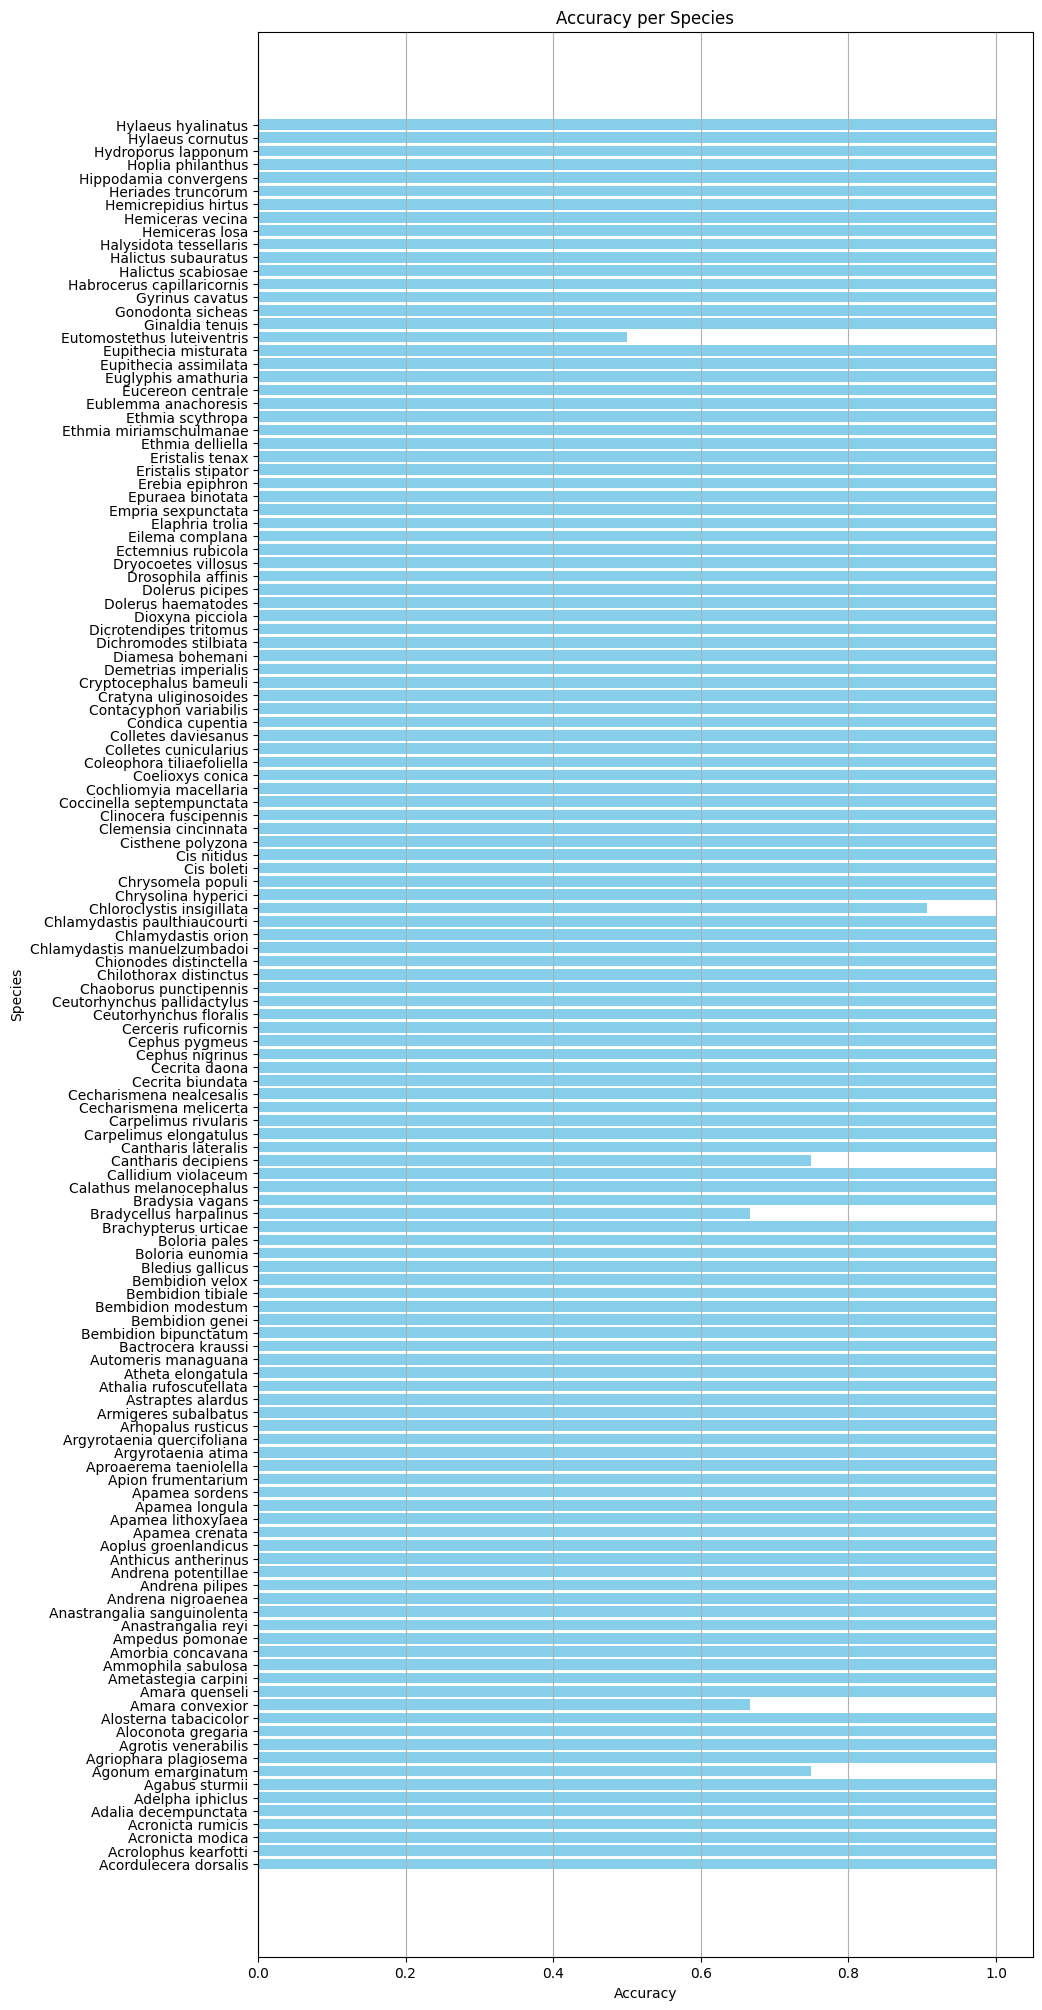

In [63]:
show_accuracy_per_species(accuracy_per_species)

Accuracy per genus:
Acronicta: 0.9491525423728814
Adelpha: 0.36792452830188677
Aedes: 0.3111111111111111
Agabus: 0.8666666666666667
Agonum: 0.8823529411764706
Agriophara: 0.0
Amara: 0.9814814814814815
Amaxia: 0.7866666666666666
Amorbia: 1.0
Andrena: 0.7924528301886793
Anomis: 0.9789915966386554
Anopheles: 0.7692307692307693
Antaeotricha: 0.03571428571428571
Apamea: 1.0
Aproaerema: 1.0
Arge: 0.46153846153846156
Argyrotaenia: 0.975609756097561
Astraptes: 0.1510204081632653
Atheta: 1.0
Athous: 1.0
Automeris: 0.7159533073929961
Bactrocera: 0.25
Bembidion: 0.9914529914529915
Bradycellus: 0.6666666666666666
Calliphora: 0.9230769230769231
Cantharis: 1.0
Carpelimus: 1.0
Cecharismena: 1.0
Cecrita: 0.17142857142857143
Cerceris: 1.0
Ceutorhynchus: 1.0
Chionodes: 1.0
Chironomus: 1.0
Chlamydastis: 0.9846153846153847
Chloroclystis: 0.975
Choristoneura: 1.0
Cisthene: 0.8876404494382022
Clemensia: 0.9387755102040817
Coelioxys: 1.0
Coleophora: 1.0
Colletes: 1.0
Condica: 0.9117647058823529
Crambus: 1.0


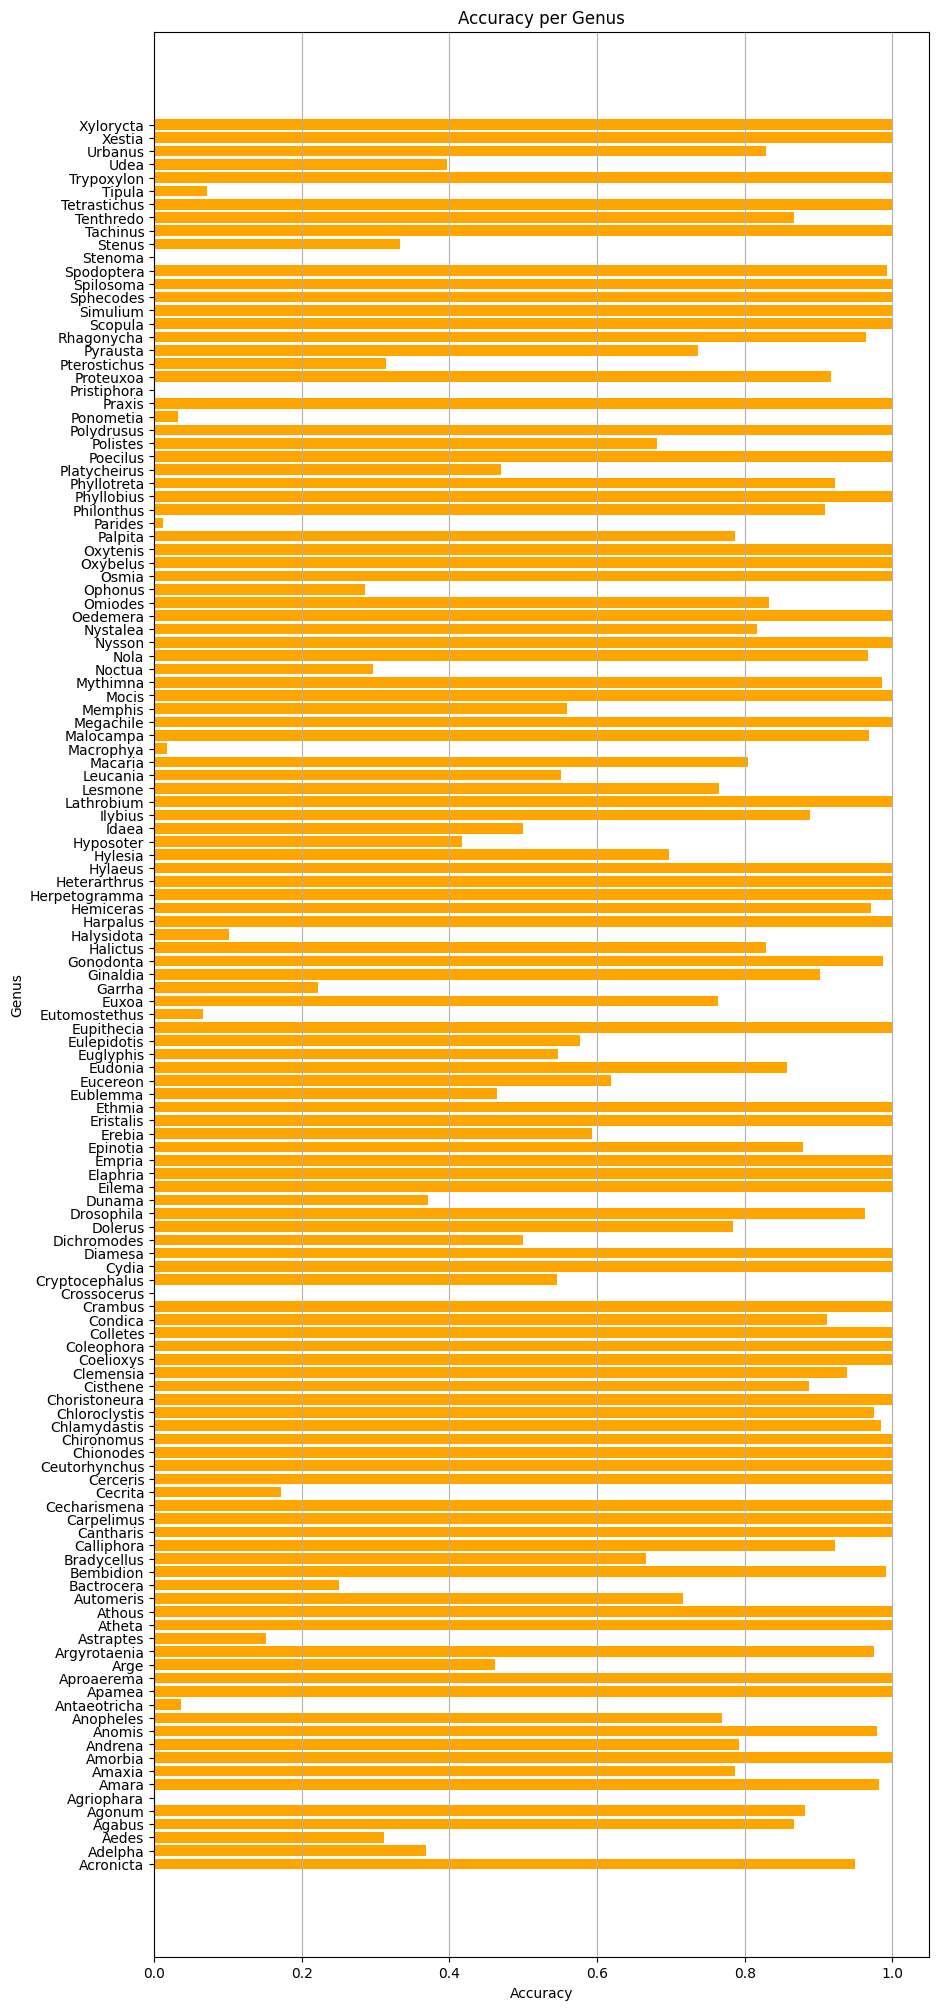

In [64]:
show_accuracy_per_genus(accuracy_per_genus)

Compute the accuracies for different thresholds.

In [65]:
species_accuracies = []
genus_accuracies = []

# Condense threshold values near 1 for the plot
linear_space = np.linspace(0, 1, 40)
condensed_space = 1 - (1 - linear_space) ** 3
threshold_values = 0.9 + 0.1 * condensed_space

for threshold in threshold_values:
    species_accuracy_threshold, genus_accuracy_threshold, _, _ = test(model, threshold, batch_size)
    species_accuracies.append(species_accuracy_threshold)
    genus_accuracies.append(genus_accuracy_threshold)

Plot the Species Accuracy - Genus Accuracy curve.

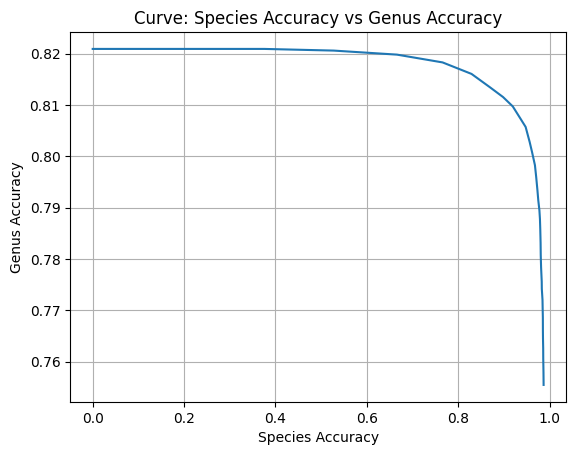

In [66]:
plt.plot(species_accuracies, genus_accuracies, marker=' ')
plt.xlabel('Species Accuracy')
plt.ylabel('Genus Accuracy')
plt.title('Curve: Species Accuracy vs Genus Accuracy')
plt.grid(True)
plt.show()

We also plot the position of the accuracies with the best threshold found during validation.

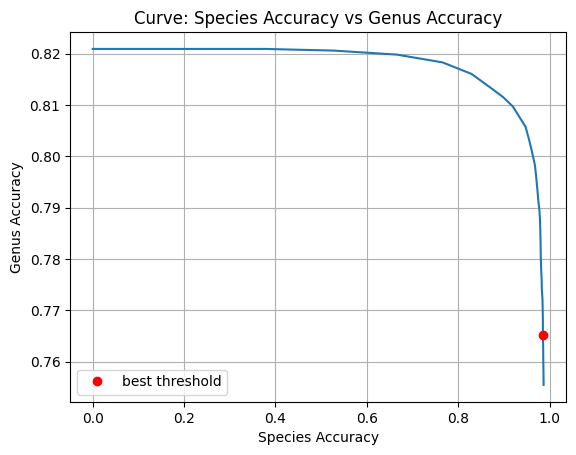

In [67]:
plt.plot(species_accuracies, genus_accuracies, marker=' ')
plt.plot(species_accuracy, genera_accuracy,'ro', label='best threshold')
plt.legend(loc="lower left")
plt.xlabel('Species Accuracy')
plt.ylabel('Genus Accuracy')
plt.title('Curve: Species Accuracy vs Genus Accuracy')
plt.grid(True)
plt.show()

We compute the described species accuracy by species and the undescibed species accuracy by genera by predicting only species (threshold = 0) and only genus, respectively (threshold = 1).

In [68]:
only_species_accuracy, _, accuracy_per_species, _ = test(model, 0, batch_size)
_, only_genera_accuracy, _, accuracy_per_genus = test(model, 1, batch_size)

print(f"Final model only described species accuracy: ", only_species_accuracy)
print(f"Final model only undescribed species accuracy: ", only_genera_accuracy)

Final model only described species accuracy:  0.9947745310245308
Final model only undescribed species accuracy:  0.8209434759540032


Accuracy per species:
Acordulecera dorsalis: 1.0
Acrolophus kearfotti: 1.0
Acronicta modica: 1.0
Acronicta rumicis: 1.0
Adalia decempunctata: 1.0
Adelpha iphiclus: 1.0
Agabus sturmii: 1.0
Agonum emarginatum: 1.0
Agriophara plagiosema: 1.0
Agrotis venerabilis: 1.0
Aloconota gregaria: 1.0
Alosterna tabacicolor: 1.0
Amara convexior: 0.6666666666666666
Amara quenseli: 1.0
Ametastegia carpini: 1.0
Ammophila sabulosa: 1.0
Amorbia concavana: 1.0
Ampedus pomonae: 1.0
Anastrangalia reyi: 1.0
Anastrangalia sanguinolenta: 1.0
Andrena nigroaenea: 1.0
Andrena pilipes: 1.0
Andrena potentillae: 1.0
Anthicus antherinus: 1.0
Aoplus groenlandicus: 1.0
Apamea crenata: 1.0
Apamea lithoxylaea: 1.0
Apamea longula: 1.0
Apamea sordens: 1.0
Apion frumentarium: 1.0
Aproaerema taeniolella: 1.0
Argyrotaenia atima: 1.0
Argyrotaenia quercifoliana: 1.0
Arhopalus rusticus: 1.0
Armigeres subalbatus: 1.0
Astraptes alardus: 1.0
Athalia rufoscutellata: 1.0
Atheta elongatula: 1.0
Automeris managuana: 1.0
Bactrocera krauss

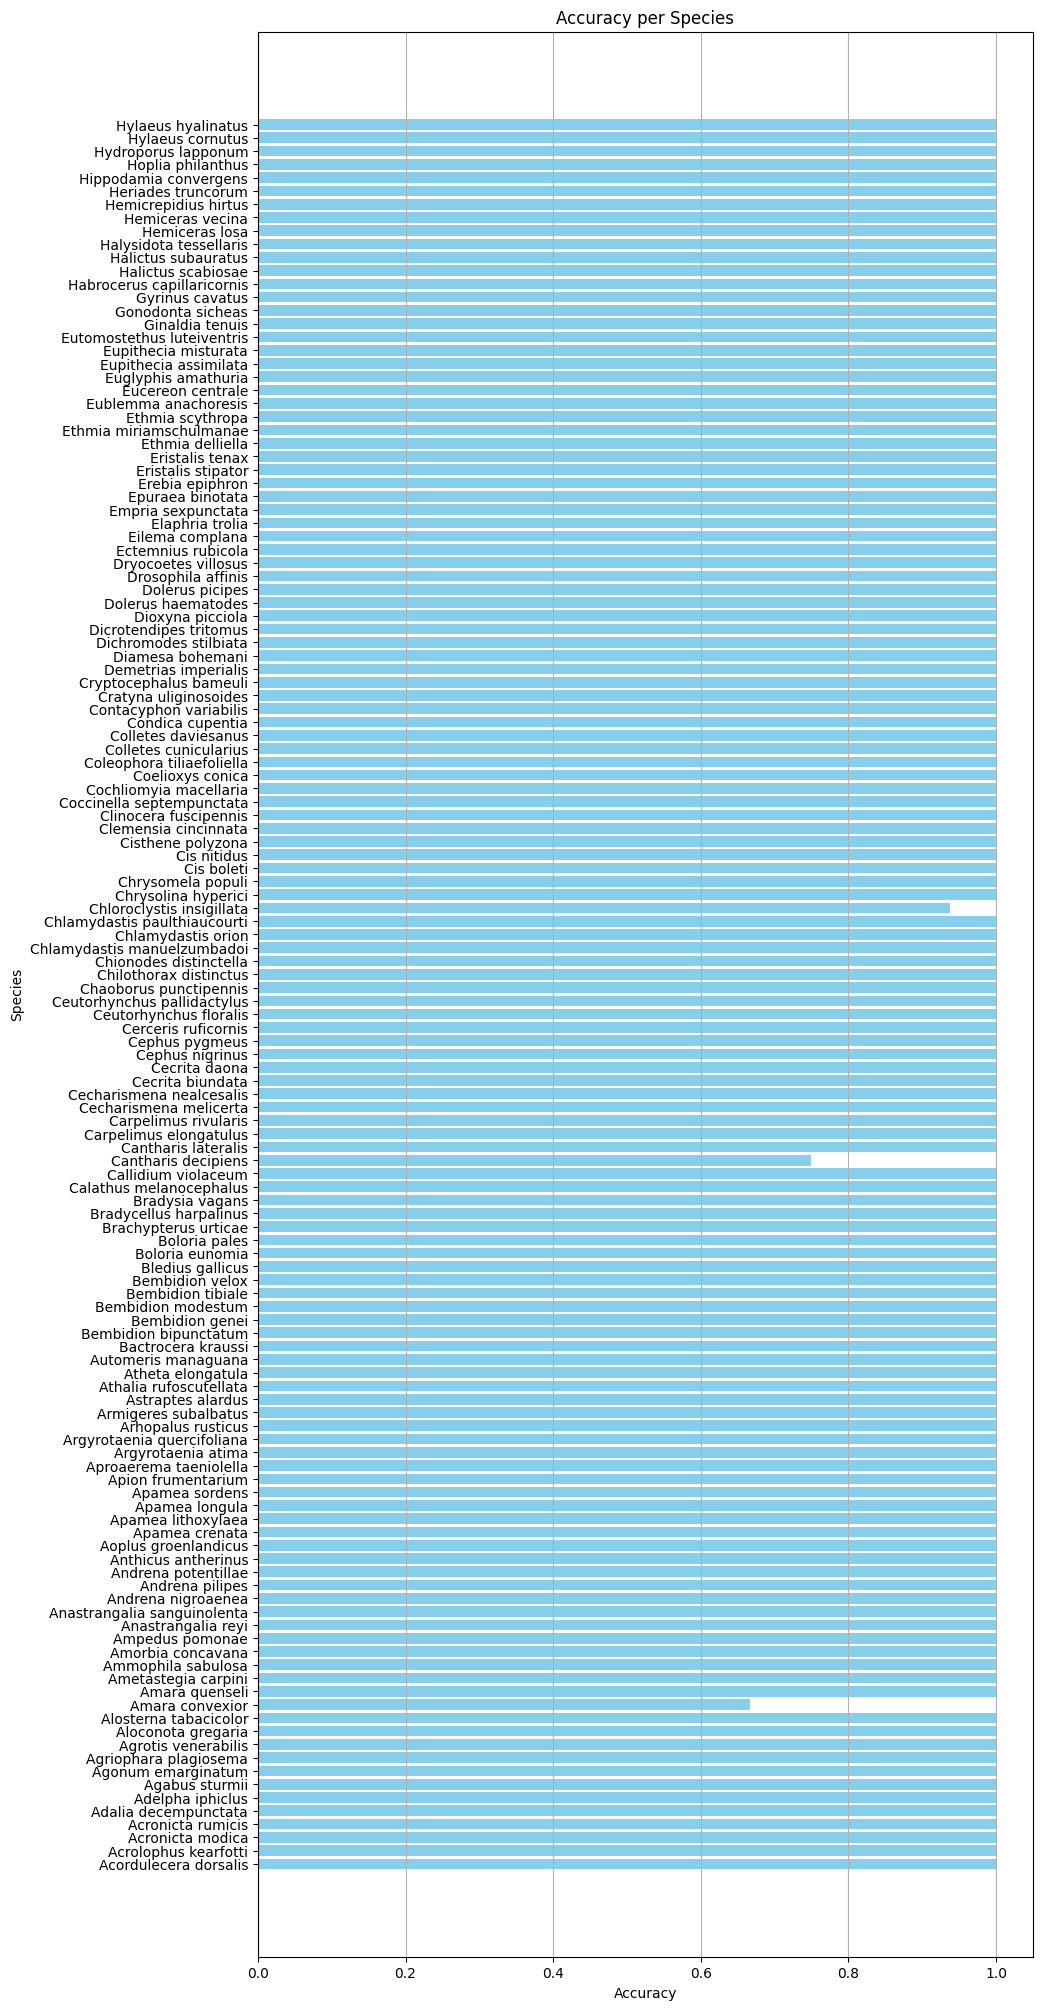

In [69]:
show_accuracy_per_species(accuracy_per_species)

Accuracy per genus:
Acronicta: 0.9491525423728814
Adelpha: 1.0
Aedes: 0.3111111111111111
Agabus: 0.8666666666666667
Agonum: 0.9215686274509803
Agriophara: 0.0
Amara: 0.9814814814814815
Amaxia: 0.7866666666666666
Amorbia: 1.0
Andrena: 1.0
Anomis: 0.9789915966386554
Anopheles: 0.8461538461538461
Antaeotricha: 0.03571428571428571
Apamea: 1.0
Aproaerema: 1.0
Arge: 1.0
Argyrotaenia: 0.975609756097561
Astraptes: 1.0
Atheta: 1.0
Athous: 1.0
Automeris: 0.7159533073929961
Bactrocera: 0.5
Bembidion: 0.9914529914529915
Bradycellus: 0.6666666666666666
Calliphora: 0.9230769230769231
Cantharis: 1.0
Carpelimus: 1.0
Cecharismena: 1.0
Cecrita: 0.17142857142857143
Cerceris: 1.0
Ceutorhynchus: 1.0
Chionodes: 1.0
Chironomus: 1.0
Chlamydastis: 0.9846153846153847
Chloroclystis: 0.975
Choristoneura: 1.0
Cisthene: 0.8876404494382022
Clemensia: 1.0
Coelioxys: 1.0
Coleophora: 1.0
Colletes: 1.0
Condica: 0.9117647058823529
Crambus: 1.0
Crossocerus: 0.0
Cryptocephalus: 0.5454545454545454
Cydia: 1.0
Diamesa: 1.0
Di

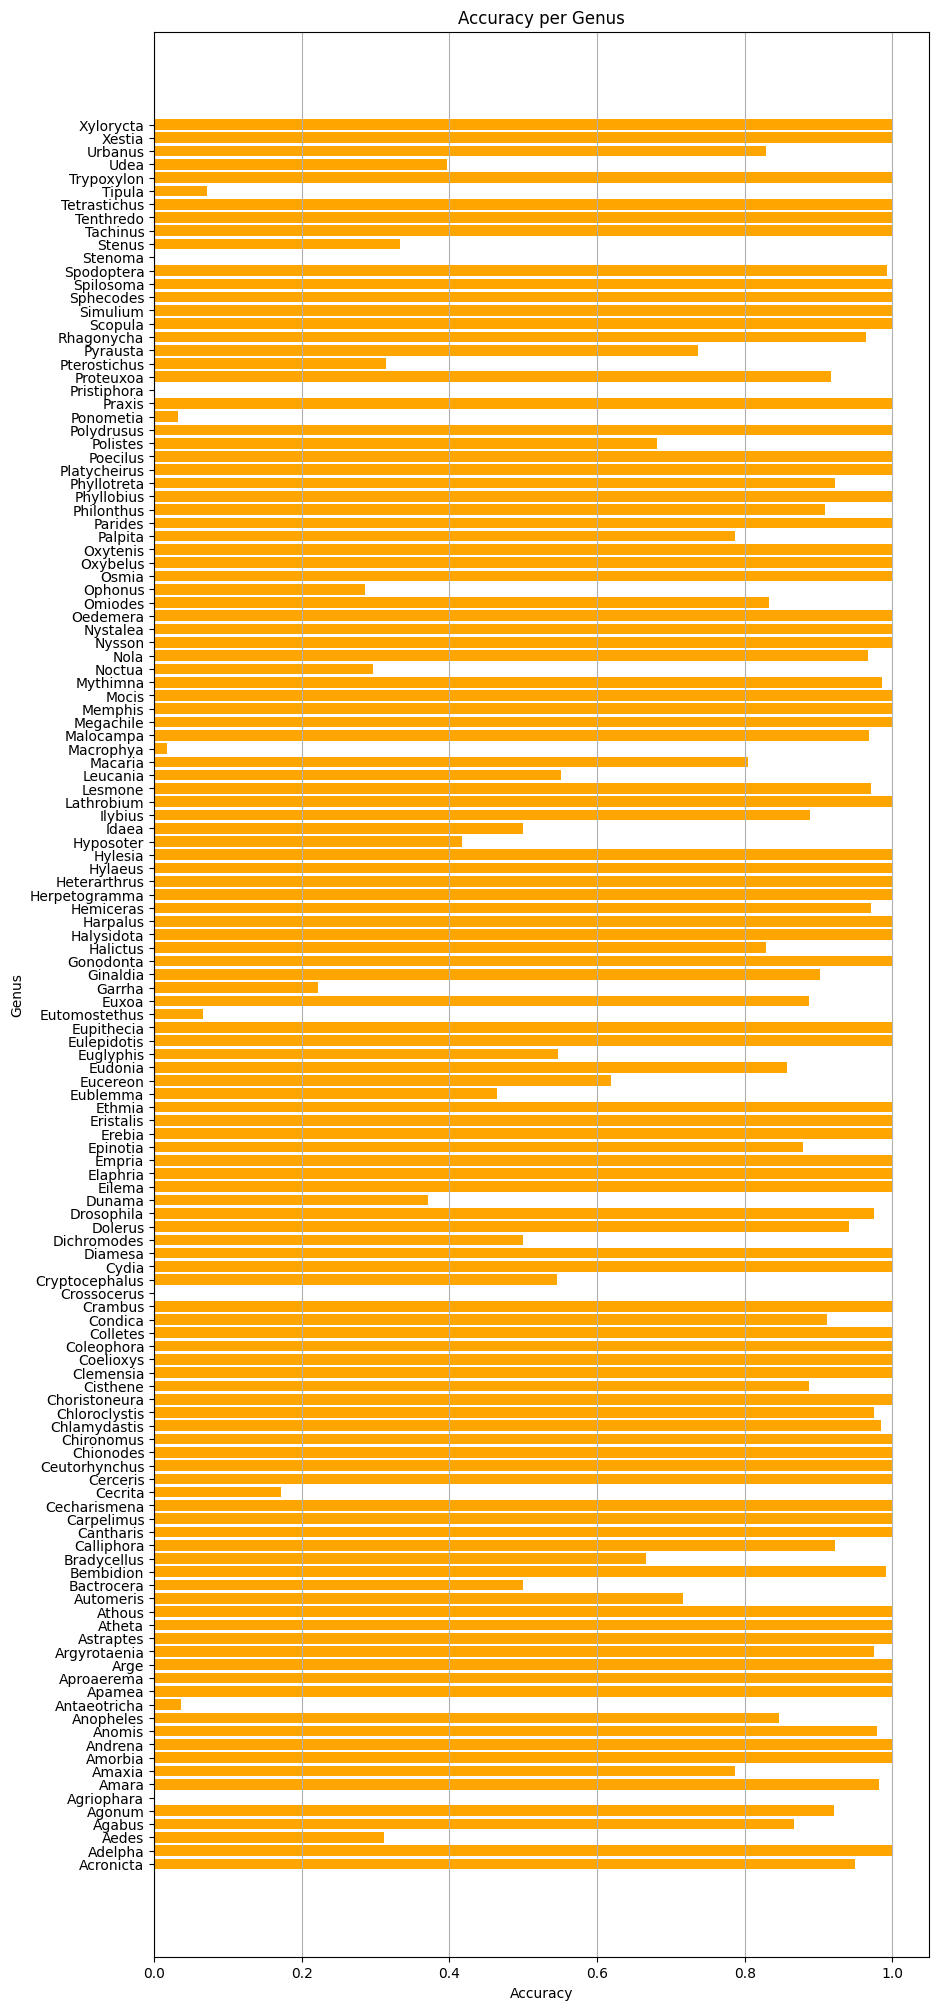

In [70]:
show_accuracy_per_genus(accuracy_per_genus)